In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [9]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [10]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

In [12]:
n_train = train_data.shape[0]
# 这里的 .astype 强制类型转化，是为了避免 bool 类型被 numpy 误认为 object 类型，影响 tensor 转化
train_features = torch.tensor(all_features[:n_train].values.astype(float), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values.astype(float), dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)


In [13]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

In [14]:
def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 64),
        nn.ReLU(), 
        # nn.Dropout(p=0.5),
        nn.Linear(64, 1)
    )
    return net

def init_weights(m):
    # 判断当前层是否是全连接层 (Linear)
    if type(m) == nn.Linear:
        # 权重：使用 Xavier 初始化 (适合 Tanh/Sigmoid) 或 Kaiming 初始化 (适合 ReLU)
        nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)
        # 偏置：通常初始化为 0

In [15]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # clipped_preds_log = net(features)
    # rmse = torch.sqrt(loss(clipped_preds_log, torch.log(labels)))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [16]:
def train(net, train_features, train_labels, test_features, test_labels, batch_size, lr, weight_decay, num_epochs):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size=batch_size)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # # 这里尝试训练 X 趋向于 log y，在最后通过 exp 还原 y
            # y_log = torch.log(y)
            
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


In [17]:
def get_k_fold_data(k, i, X, y):
    assert k > 0
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train == None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
    
    return X_train,y_train, X_valid, y_valid

In [18]:
def k_fold(k, X_train, y_train, batch_size, lr, weight_decay, num_epochs):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        net.apply(init_weights)
        train_ls, valid_ls = train(net, *data, 
                                   batch_size=batch_size, 
                                   lr = lr, 
                                   weight_decay = weight_decay, 
                                   num_epochs = num_epochs)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        d2l.plot(list(range(1, num_epochs + 1)), 
                 [train_ls, valid_ls], 
                 xlabel='epochs',
                 ylabel = 'rmse',
                 xlim=[1, num_epochs],
                 legend=['train', 'valid'],
                 yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

        

折1，训练log rmse0.043172, 验证log rmse0.142272
折2，训练log rmse0.048777, 验证log rmse0.160702
折3，训练log rmse0.062945, 验证log rmse0.172525
折4，训练log rmse0.050990, 验证log rmse0.124259
折5，训练log rmse0.043128, 验证log rmse0.183807
5-折验证: 平均训练log rmse: 0.049802, 平均验证log rmse: 0.156713


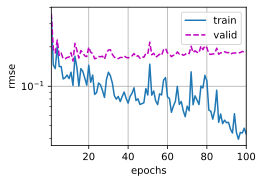

In [19]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs=num_epochs, lr=lr,
                          weight_decay=weight_decay, batch_size=batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [23]:
def train_and_pred(train_features, train_labels, test_features, 
                   test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    net.apply(init_weights)
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                        batch_size, lr, weight_decay, num_epochs)
    d2l.plot(list(range(num_epochs)), [train_ls], xlabel='epochs', ylabel='log_rmse', 
             xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.051751


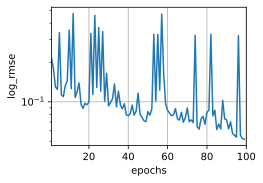

In [24]:
train_and_pred(train_features=train_features, test_features = test_features, 
               train_labels = train_labels, test_data=test_data,
               num_epochs=num_epochs, lr=lr, weight_decay=weight_decay, batch_size=batch_size)